# Hotel Booking Cancellation/Honoring Prediction Model
Using Random Forest and XGBoost Models

In [10]:
import sys
import io
import requests
import warnings
from sklearn import tree, metrics
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
import dtreeviz
from pathlib import Path
import pandas as pd
import numpy as np
import sklearn
import tensorflow as tf
from tensorflow import keras
import gymnasium as gym
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns


# Make notebook output stable across runs
random_state = 1000
np.random.seed(random_state)
tf.random.set_seed(random_state)

# Plot settings
%matplotlib inline
sns.set()
mpl.rc('font', size=14)
mpl.rc('axes', labelsize=14, titlesize=14)
mpl.rc('legend', fontsize=14)
mpl.rc('xtick', labelsize=10)
mpl.rc('ytick', labelsize=10)
mpl.rc('animation', html='jshtml')

# Exploratory Analysis

In [11]:
# initial data
df = pd.read_csv('hotel.csv')

df.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


In [12]:
df.describe()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
count,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000
mean,1.844962,0.105279,0.810724,2.204300,0.030986,85.232557,2017.820427,7.423653,15.596995,0.025637,0.023349,0.153411,103.423539,0.619655
std,0.518715,0.402648,0.870644,1.410905,0.173281,85.930817,0.383836,3.069894,8.740447,0.158053,0.368331,1.754171,35.089424,0.786236
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,17.000000,2018.000000,5.000000,8.000000,0.000000,0.000000,0.000000,80.300000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,57.000000,2018.000000,8.000000,16.000000,0.000000,0.000000,0.000000,99.450000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,126.000000,2018.000000,10.000000,23.000000,0.000000,0.000000,0.000000,120.000000,1.000000
max,4.000000,10.000000,7.000000,17.000000,1.000000,443.000000,2018.000000,12.000000,31.000000,1.000000,13.000000,58.000000,540.000000,5.000000


The above charts show our initial, unchanged dataset.  Overall, the data we acquired is incredibly clean, but we will make some modifications, such as creating dummy variables for some of our categorical variables.

In [13]:
# creating dummy variables for bookings 
booking = pd.get_dummies(df['booking_status'])

In [14]:
canceled = booking['Canceled']
df = df.join(canceled)

In [15]:
df_partial = df[['no_of_adults', 'no_of_children', 'lead_time', 'repeated_guest',
                'avg_price_per_room', 'no_of_special_requests', 'Canceled']]
df_partial.describe()

,no_of_adults,no_of_children,lead_time,repeated_guest,avg_price_per_room,no_of_special_requests,Canceled
count,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000
mean,1.844962,0.105279,85.232557,0.025637,103.423539,0.619655,0.327636
std,0.518715,0.402648,85.930817,0.158053,35.089424,0.786236,0.469358
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,17.000000,0.000000,80.300000,0.000000,0.000000
50%,2.000000,0.000000,57.000000,0.000000,99.450000,0.000000,0.000000
75%,2.000000,0.000000,126.000000,0.000000,120.000000,1.000000,1.000000
max,4.000000,10.000000,443.000000,1.000000,540.000000,5.000000,1.000000


The above table shows descriptive statistics of some chosen features that we have predicted will play an important role in our classification model.

In [16]:
Canceled_Bookings = df.loc[df['Canceled']==1]
Canceled_Bookings.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.0,0,Canceled,1
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.0,0,Canceled,1
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.5,0,Canceled,1
5,INN00006,2,0,0,2,Meal Plan 2,0,Room_Type 1,346,2018,9,13,Online,0,0,0,115.0,1,Canceled,1
12,INN00013,2,0,2,1,Not Selected,0,Room_Type 1,30,2018,11,26,Online,0,0,0,88.0,0,Canceled,1


In [17]:
Honored_Bookings = df.loc[df['Canceled']==0]
Honored_Bookings.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,Canceled
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled,0
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled,0
6,INN00007,2,0,1,3,Meal Plan 1,0,Room_Type 1,34,2017,10,15,Online,0,0,0,107.55,1,Not_Canceled,0
7,INN00008,2,0,1,3,Meal Plan 1,0,Room_Type 4,83,2018,12,26,Online,0,0,0,105.61,1,Not_Canceled,0
8,INN00009,3,0,0,4,Meal Plan 1,0,Room_Type 1,121,2018,7,6,Offline,0,0,0,96.90,1,Not_Canceled,0


The above charts show the heads of the data for canceled bookings and honored bookings.

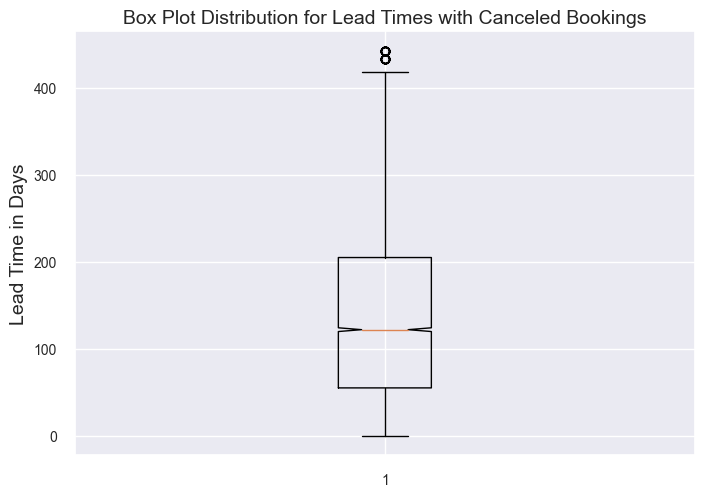

In [18]:
plt.boxplot(Canceled_Bookings['lead_time'], plt.title("Box Plot Distribution for Lead Times with Canceled Bookings"))
plt.ylabel("Lead Time in Days")

plt.show()

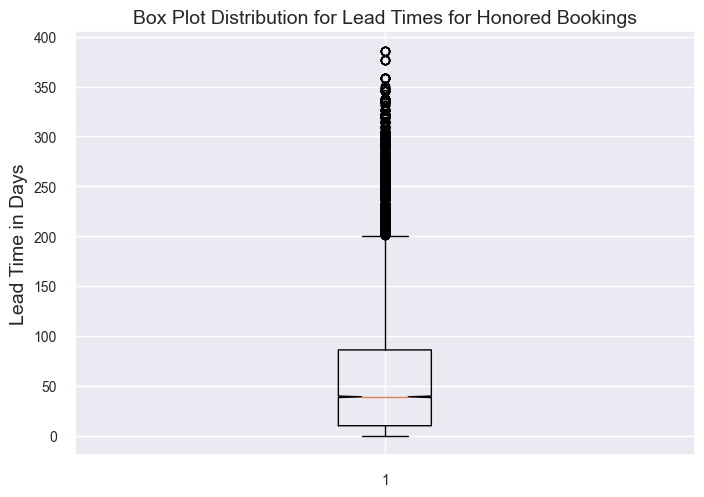

In [19]:
plt.boxplot(Honored_Bookings['lead_time'], plt.title("Box Plot Distribution for Lead Times for Honored Bookings"))
plt.ylabel("Lead Time in Days")
plt.show()

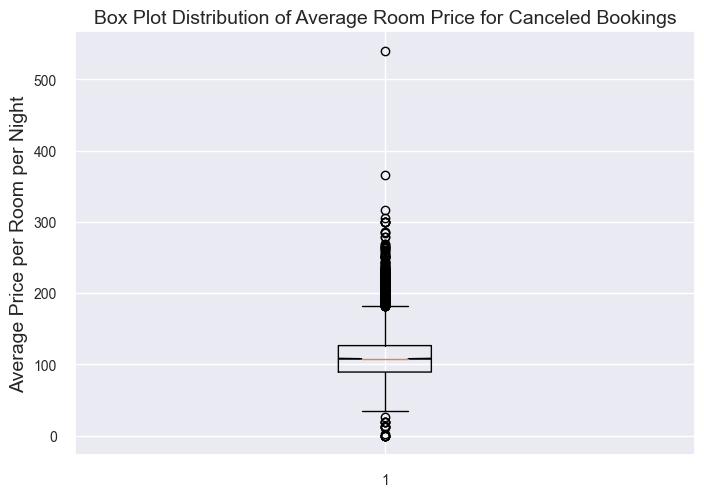

In [20]:
price_canceled = df.loc[df['Canceled'] ==1]
plt.boxplot(price_canceled['avg_price_per_room'], plt.title("Box Plot Distribution of Average Room Price for Canceled Bookings"))
plt.ylabel("Average Price per Room per Night")
plt.show()

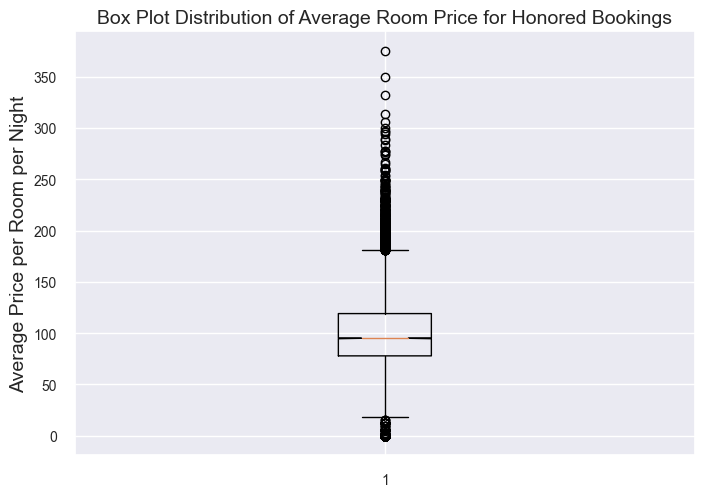

In [21]:
price_honored = df.loc[df['Canceled']==0]
plt.boxplot(price_honored['avg_price_per_room'], plt.title("Box Plot Distribution of Average Room Price for Honored Bookings"))
plt.ylabel("Average Price per Room per Night")
plt.show()

# Random Forest Model

In [22]:
# perform a train test split with the data
num_features = df[['no_of_adults', 'no_of_children','no_of_weekend_nights', 'no_of_week_nights', 'required_car_parking_space',
       'lead_time', 'arrival_year', 'arrival_month', 'arrival_date', 'repeated_guest', 'no_of_previous_cancellations',
       'no_of_previous_bookings_not_canceled', 'avg_price_per_room', 'no_of_special_requests']]

meal = pd.get_dummies(df['type_of_meal_plan'])
room = pd.get_dummies(df['room_type_reserved'])
segment = pd.get_dummies(df['market_segment_type'])
cat_features = pd.concat([meal, room, segment], axis=1)

X = pd.concat([num_features, cat_features], axis=1)

y = df['Canceled']

(X_train, X_test, 
 y_train, y_test) = train_test_split(X, y, test_size=0.15,
                                     stratify=y, random_state=random_state)

In [15]:
rnd_clf = RandomForestClassifier(n_jobs = 2, random_state = random_state)

search_parameters = {
    'n_estimators':range(25, 150, 25),
    'max_depth':range(7,12)
}

grid_clf = GridSearchCV(rnd_clf, search_parameters)
grid_clf.fit(X_train, y_train)
print(f'Accuracy: {grid_clf.best_score_:.3f}')
grid_clf.best_params_

Accuracy: 0.879


{'max_depth': 11, 'n_estimators': 100}

In [16]:
y_pred = grid_clf.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.8761484748254318

# XGBoost Model

In [22]:
# trying with gradient boosting
search_parameters2 = {
    'n_estimators':np.arange(25, 150, 25),
    'max_depth':np.arange(7,12),
    'learning_rate':np.arange(0.4, 0.7, 0.1)
}

xgb_clf = XGBClassifier(random_state = random_state)
grid_clf = GridSearchCV(xgb_clf, search_parameters2)
grid_clf.fit(X_train, y_train)
print(f'Accuracy: {grid_clf.best_score_:.3f}')
grid_clf.best_params_

Accuracy: 0.899


{'learning_rate': 0.4, 'max_depth': 9, 'n_estimators': 125}

In [23]:
y_pred = grid_clf.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.8972804116133775

In [23]:
XGB_best = XGBClassifier(random_state=random_state, max_depth=9, n_estimators=125)
XGB_best.fit(X_train, y_train)
importances = XGB_best.feature_importances_
idx = np.argsort(importances)[::-1]
print(*X_train.columns[idx], sep = "\n")

Online
required_car_parking_space
no_of_special_requests
repeated_guest
lead_time
arrival_year
no_of_adults
Corporate
Meal Plan 2
arrival_month
avg_price_per_room
Aviation
no_of_weekend_nights
Room_Type 5
Meal Plan 1
Offline
no_of_week_nights
Room_Type 1
arrival_date
Room_Type 4
Room_Type 2
no_of_children
Not Selected
Room_Type 7
no_of_previous_bookings_not_canceled
Room_Type 6
no_of_previous_cancellations
Meal Plan 3
Complementary
Room_Type 3


In [24]:
importances

array([0.03405363, 0.01003546, 0.01890789, 0.01323696, 0.08550312,
       0.04434013, 0.03923716, 0.02501322, 0.01233572, 0.05226092,
       0.00404516, 0.00620594, 0.02393915, 0.07483386, 0.01724187,
       0.02904751, 0.        , 0.00976022, 0.01309736, 0.01119918,
       0.        , 0.01146775, 0.01829262, 0.00515742, 0.00818319,
       0.02165665, 0.        , 0.03136589, 0.01613529, 0.36344674],
      dtype=float32)

In [33]:
importance = [importances]
feature_importances = pd.DataFrame({'Feature' : X.columns,
                                   'Importance' : importances,
                                   })
feature_importances

,Feature,Importance
0,no_of_adults,0.034054
1,no_of_children,0.010035
2,no_of_weekend_nights,0.018908
3,no_of_week_nights,0.013237
4,required_car_parking_space,0.085503
5,lead_time,0.044340
6,arrival_year,0.039237
7,arrival_month,0.025013
8,arrival_date,0.012336
9,repeated_guest,0.052261


In [46]:
feature_importances = feature_importances.sort_values('Importance', ascending=True)
feature_importances

,Feature,Importance
20,Room_Type 3,0.000000
26,Complementary,0.000000
16,Meal Plan 3,0.000000
10,no_of_previous_cancellations,0.004045
23,Room_Type 6,0.005157
11,no_of_previous_bookings_not_canceled,0.006206
24,Room_Type 7,0.008183
17,Not Selected,0.009760
1,no_of_children,0.010035
19,Room_Type 2,0.011199


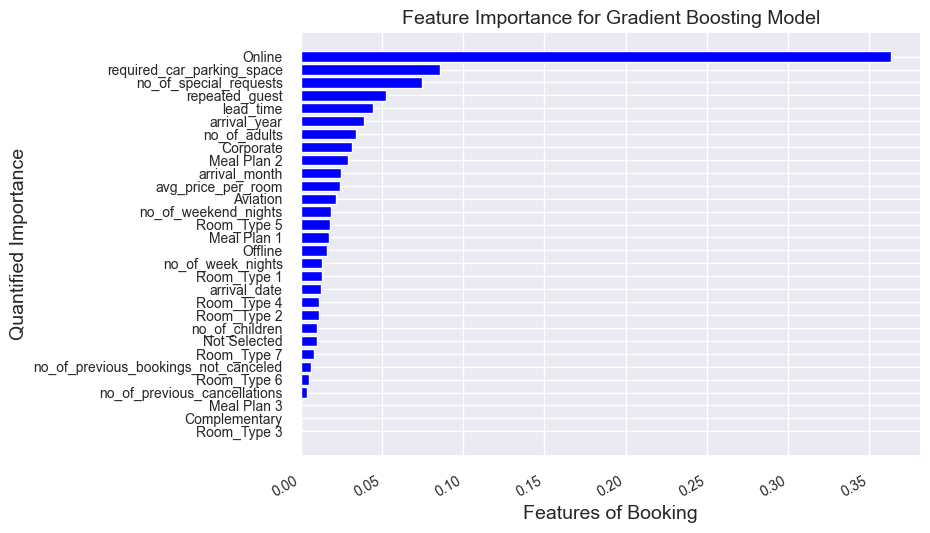

In [47]:
fig = plt.figure()
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color = "blue")
plt.xticks(rotation=30, ha='right')
plt.xlabel("Features of Booking")
plt.ylabel("Quantified Importance")
plt.title("Feature Importance for Gradient Boosting Model")
plt.show()